# SWOT Oceanography with PO.DAAC
## Subset SWOT L2 SSH using Dask

Jinbo Wang\
SWOT Scientist/PODAAC Project Scientist

3/15/2022

# Introduction 
Use Dask to parallel subset the SWOT L2 SSH granules. 

## Simulated L2 SSH

The [SWOTsimulator](https://swot-simulator.readthedocs.io/en/latest/) was used on two global ocean simulations (LLC4320 and GLORYS) following the error specification described in [Level 2 KaRIn Low Rate Sea Surface Height Product PDF file (D-56407)](https://podaac-tools.jpl.nasa.gov/drive/files/misc/web/misc/swot_mission_docs/pdd/D-56407_SWOT_Product_Description_L2_LR_SSH_20200806.pdf). The simulator was based on Gaultier et al. first version but was almost completely rewritten, while keeping the error budget largely unchanged. (The error representation is claimed to be better but needs more documentation.) The CNES team is the creator of these products. The 8 datasets are listed as follows: 
```
SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1          17686 files
SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1         17564 files
SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_CALVAL_V1          17686 files
SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_SCIENCE_V1         17564 files
SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1    10288 files
SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1   10218 files
SWOT_SIMULATED_L2_NADIR_SSH_ECCO_LLC4320_CALVAL_V1    10287 files
SWOT_SIMULATED_L2_NADIR_SSH_ECCO_LLC4320_SCIENCE_V1   10218 files
```

The links to these datasets on PODAAC website or Earthdata search page. 

* [Eight simulated L2 SSH datasets on PO.DAAC website.](https://podaac.jpl.nasa.gov/datasetlist?search=simulated%20level-2)
* [Four GLORYS datasets from Earthdata search](https://search.earthdata.nasa.gov/search?q=glorys)
* [Four ECCO_LLC4320 datasets from Earthdata search](https://search.earthdata.nasa.gov/search?q=ECCO%20LLC4320&fl=2%20-%20Geophys.%20Variables%2C%20Sensor%20Coordinates)

The ECCO_LLC4320-based products cover one-year duration with >10k files (granules in Earthdata language) in each collection. The GLORYS-based products cover about 20 months with >17k files in each collection.

## Relevant content in the simulated L2 SSH files
There are too much information in these datasets for this short cloud hackathon. For example, there are 92 variables in the KaRIn products. The hackathon participants are strongly encouraged to read the the [product description](https://podaac-tools.jpl.nasa.gov/drive/files/misc/web/misc/swot_mission_docs/pdd/D-56407_SWOT_Product_Description_L2_LR_SSH_20200806.pdf) to understand the meaning of different variables. For this exercise, the variables with "simulated" keyword are most relevant: 
1. 'simulated_true_ssh_karin'
1. 'simulated_error_baseline_dilation'
1. 'simulated_error_roll'
1. 'simulated_error_phase'
1. 'simulated_error_timing'
1. 'simulated_error_karin'
1. 'simulated_error_orbital'
1. 'simulated_error_troposphere'


# Simulated L2 fields with errors

Run the following code blocks in US-WEST-2 to browse the datasets and the data content and visualize the swaths of L2 SSH and errors. These code blocks are based on Mike Gangl's "direct S3 access" notebook. 

In [ ]:
from matplotlib import pylab as plt
import xarray as xr
import numpy as np
from pprint import pprint

def init_S3FileSystem(daac='podaac'):
    '''
    This function will return a S3filesystem using s3fs.
    
    Parameter
    =========
    daac: string
          The name of the NASA DAAC where the data are hosted. The options are ['podaac','lpdaac'] and others to be added
    
    Return
    ======
    s3: a s3fs handle
    '''
    
    import requests,s3fs
    s3_cred_endpoint = {
        'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
        'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'}

    temp_creds_url = s3_cred_endpoint[daac]
    creds = requests.get(temp_creds_url).json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'])
    return s3


def open_swot_L2SSH(s3sys, filename):
    '''
    Open a file in S3 using xarray. 
    
    Parameter
    ========
    filename: S3 link to the data file. 
    
    Return
    ======
    xarray Dataset
    '''
    
    return xr.open_dataset(s3sys.open(filename))

def swot_karin_l2_subset(s3sys,filename, var_name, bbox, out_folder):
    """
    filenames: string 
         The S3 links to one file 
         
    bbox: list 
         [west, east, south, north] borders
         
    var_name: string 
         Variable name
        
    """

    w,e,s,n=bbox
    
    w=(w+360)%360;e=(e+360)%360 
    if e<w: #cross 360-degree, change w to negative
        w=w-360 
    

    fn_out=filename.split('/')[-1].replace('.nc','_subset_%i%i%i%i.nc'%(w,e,s,n) )

    data=xr.open_dataset(s3sys.open(filename))

    lat,lon=data['latitude_nadir'].data,data['longitude_nadir'].data
    lon=(lon+360)%360
    if w<0: #cross 
        lon[lon>180]-=360

    msk=(lat>s)&(lat<n)&(lon>w)&(lon<e)

    if msk.sum()>1: #if there is any data within this domain
        dout={}
        dout[var_name]=data[var_name][msk,:]
        dout['time']=data['time'][msk]
        
        xr.Dataset(dout).to_netcdf('%s/%s'%(out_folder,fn_out) )
        del dout, data
    return

def swot_karin_l2_subset_dask(scheduler,filenames, 
                              var_name, bbox, 
                              out_folder):
    from dask.distributed import Client
    import dask
    
    s3sys=init_S3FileSystem()

    client=Client(scheduler)
    
    c=[]
    
    for fn in filenames:
        c.append( dask.delayed(swot_karin_l2_subset)(s3sys,fn, 
                              var_name, bbox, 
                              out_folder) )
    dask.compute(*c)
    
    client.close()
    
    return
    

## Subsetting using Dask delay

Steps to use Dask within jupyter-notebook
1. Go to the Dask extension (third button on the left-hand side vertical bar). 
1. Start a Dask cluster by clicking "+" NEW. You will get the following: 
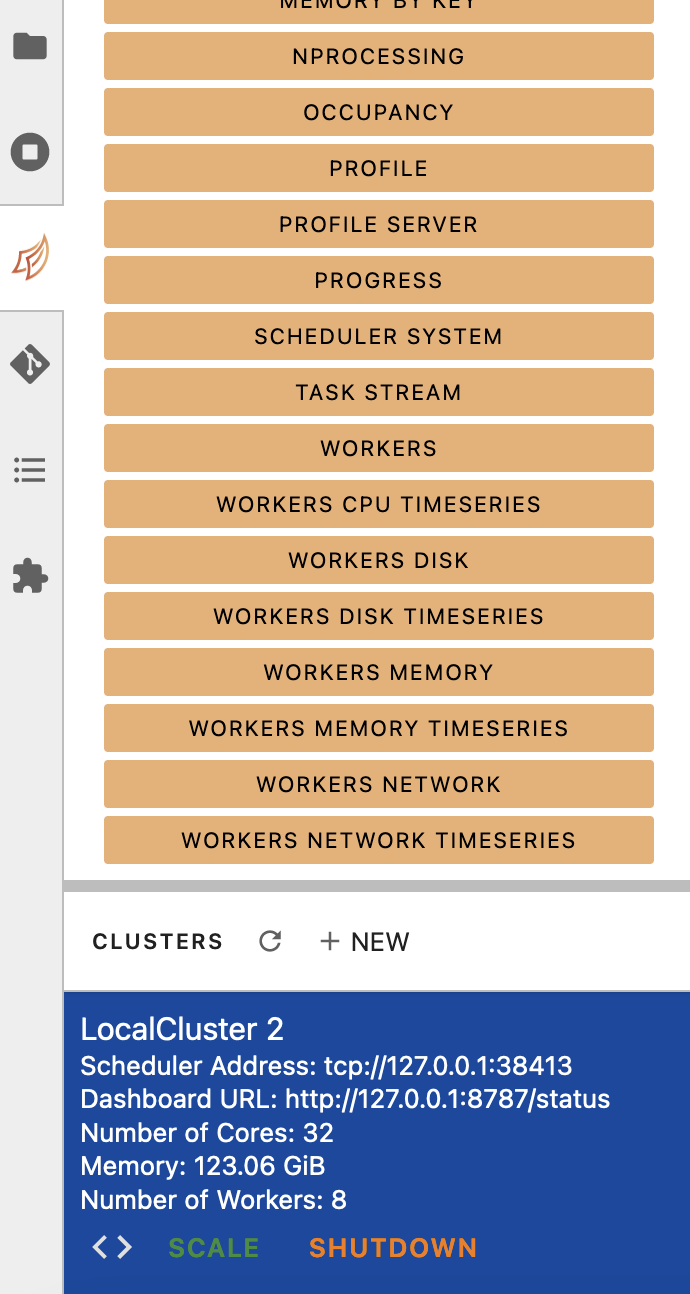

1. Use <font color='green'>"SCALE"</font> to maximumize the number of workers according to your AWS instance.  
1. Copy <font color='red'>tcp://127.0.0.1:?????</font> link from the LocalCluster and replace the following scheduler variable. 


In [ ]:
scheduler='tcp://127.0.0.1:34721'
out_folder='/home/jovyan/podaac_hackathon_swot_20220316/subsets/' #change this to your folder

In [ ]:
#The 8 datasets have short names starting from "SWOT". 
#You may get more than these 8 collections in the future after new SWOT data ingested. 
#The following wildcard will give you the 8 collections for now.
#%%timeit

s3sys=init_S3FileSystem()

s3path="s3://podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1/*nc"  
#Search all collections that fit to the wildcard.
fns= s3sys.glob(s3path)
print(len(fns))

swot_karin_l2_subset_dask(scheduler,fns[:1000], 
                          'simulated_true_ssh_karin', 
                          [-126,-120,30,50], 
                           out_folder=out_folder )


## Print the content of an example file

Load and plot one subset.

In [ ]:
from glob import glob
fns_local=sorted(glob('subsets/*nc'))

data=xr.open_dataset(fns_local[10])
data

Let us look at one error field "simulated_error_troposphere".

In [ ]:
plt.scatter(data['longitude'],data['latitude'],s=1,c=data['simulated_true_ssh_karin'])

<div class="alert alert-block alert-info"><b>Please engage with PODAAC by sharing your experience, sending feedback, and asking questions, either through podaac@podaac.jpl.nasa.gov or any of the PODAAC team members who you feel comfortable to communicate. 
    Engagement leads to better services. Go SWOT! </b>